the following code was adapted from *Sentiment Analysis with BERT and Transformers by Hugging Face using PyTorch and Python*, https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/, last accessed on 10.11.2020

install transformers-library from Hugging Face

In [ ]:
pip install transformers

import statement 

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
%matplotlib inline
random_seed = 17
np.random.seed(random_seed)
torch.manual_seed(random_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

load data from lokal folder

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving not_balanced_11K_Samples.csv to not_balanced_11K_Samples.csv


convert data to Data Frame

In [ ]:
df = pd.read_csv('not_balanced_11K_Samples.csv')
print(df.head(20))

        ID                         drugName  ... sentiment review_length
0    88957                         TriNessa  ...         2           104
1   124090                        Clonidine  ...         2            84
2   160887                          Tenuate  ...         2           156
3    55163                        Androderm  ...         1           125
4    45424                       Lorcaserin  ...         1            28
5    27447                       Paroxetine  ...         0           150
6    87684                        Trazodone  ...         2           131
7   158527                           Celexa  ...         2            69
8    51785                     Depo-Provera  ...         1           173
9   157608                     Vortioxetine  ...         2           195
10  155939                        Meloxicam  ...         0           146
11   64059  Monistat 3-Day Combination Pack  ...         1            56
12   27341                     Tri-Sprintec  ...   

define class names

In [ ]:
class_names = ['negative','neutral', 'positive']

define bert pretrained model

In [ ]:
pretrained_model = 'bert-base-cased'

load bert model

In [ ]:
bert_model = BertModel.from_pretrained(pretrained_model)

define and load tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained(pretrained_model)

define max length of reviews: 250 or 150

In [ ]:
max_length = 150

define batch_size, recommended 16 or 32; 32 doing a little bit better

In [ ]:
batch_size = 32

define epochs_number, after epoch 6 there was no progress in performance of the model

In [ ]:
num_epochs = 6

define dataset class

In [ ]:
class MedDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_length):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length = self.max_length,
            padding ="max_length",
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train/test splitting

In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = random_seed, stratify = df.sentiment.values)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = random_seed, stratify = df_test.sentiment.values)
 

create data loader

In [ ]:
def create_data_loader(df, tokenizer, max_length, batch_size, sampler):
  ds = MedDataset(
    reviews = df.review.to_numpy(),
    labels = df.sentiment.to_numpy(),
    tokenizer = tokenizer,
    max_length = max_length
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    pin_memory=True
   )

In [ ]:
train_dataloader = create_data_loader(df_train, tokenizer, max_length, batch_size, sampler = RandomSampler(df_train))
val_dataloader = create_data_loader(df_val, tokenizer, max_length, batch_size, sampler = SequentialSampler(df_val))
test_dataloader = create_data_loader(df_test, tokenizer, max_length, batch_size, sampler = SequentialSampler(df_test))

define classification layer

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

define the number of classes to classify; send model to gpu

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

define optimizer, scheduler and loss function

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)
   

function for model training

In [ ]:
def train_model(
        model,
        data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

function for model-validation

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

model training


In [ ]:
%%time

progress = defaultdict(list)
best_accuracy = 0

for epoch in range(num_epochs):

  print(f'Epoch {epoch + 1}/{num_epochs}')
  print('-' * num_epochs)

  train_acc, train_loss = train_model(
    model,
    train_dataloader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_dataloader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  progress['train_acc'].append(train_acc)
  progress['train_loss'].append(train_loss)
  progress['val_acc'].append(val_acc)
  progress['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/6
------
Train loss 0.9019231321339939 accuracy 0.6415031222123104
Val   loss 0.8295053688573165 accuracy 0.7056199821587869

Epoch 2/6
------
Train loss 0.8116656673570792 accuracy 0.7330508474576272
Val   loss 0.8141845170880707 accuracy 0.7145405887600357

Epoch 3/6
------
Train loss 0.7628743134292901 accuracy 0.7833407671721677
Val   loss 0.8121156482629373 accuracy 0.7261373773416593

Epoch 4/6
------
Train loss 0.7343467753413739 accuracy 0.8155664585191793
Val   loss 0.8143204861963299 accuracy 0.7270294380017841

Epoch 5/6
------
Train loss 0.7122598917301538 accuracy 0.8392060660124889
Val   loss 0.816073432774611 accuracy 0.7270294380017841

Epoch 6/6
------
Train loss 0.7060528336999251 accuracy 0.8450044603033007
Val   loss 0.816073432774611 accuracy 0.7270294380017841

CPU times: user 17min 31s, sys: 11min 28s, total: 28min 59s
Wall time: 29min 9s


load trained model if it exists

In [ ]:
# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

plot accuracy progress

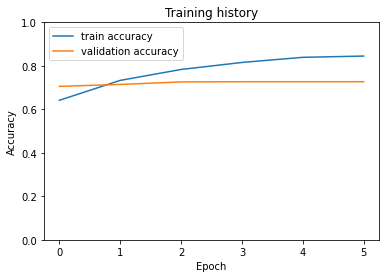

In [ ]:
plt.plot(progress['train_acc'], label='train accuracy')
plt.plot(progress['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

check model accuracy on test set

In [ ]:
test_acc, _ = eval_model(
  model,
  test_dataloader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7281639928698752

get predictions

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  true_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      true_values.extend(labels)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  true_values = torch.stack(true_values).cpu()
  return review_texts, predictions, prediction_probs, true_values

get classifikation report

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_true = get_predictions(
  model,
  test_dataloader
)
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.68      0.62      0.65       244
     neutral       0.39      0.41      0.40       200
    positive       0.85      0.86      0.85       678

    accuracy                           0.73      1122
   macro avg       0.64      0.63      0.63      1122
weighted avg       0.73      0.73      0.73      1122



make confusion matrix

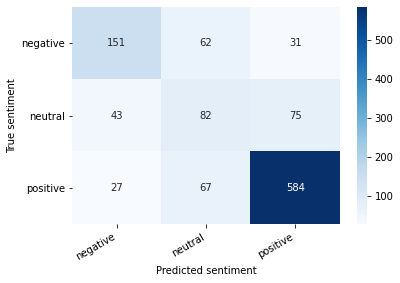

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)